# PyTorchで画像分類
## MLPによるMNIST（手書き文字）の分類
## ミニバッチ学習
## （ローカルPC上でCPU or GPU） or AWSクラウドGPU の利用

In [60]:
import torch#tensorを作成・操作するための機能、GPUの仕様も設定
import torch.nn as nn#nnを構成する部品を提供
import torch.optim as optim#SGD,adamなどの最適化関数や学習率を設定
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

In [61]:
# もしGPUが利用可能なら cuda が入る
device = "cuda" if torch.cuda.is_available() else "cpu"
print('学習に使用するデバイス：',device)

学習に使用するデバイス： cpu


# 前処理の定義 

In [62]:
transform = transforms.Compose([
    transforms.ToTensor() # 画像をTensorに変換、Channel Last → Channel First、0-255の範囲 → 0.0-1.0 に変換
])


In [63]:
train_dataset = datasets.CIFAR10(
    root="./data", 
    train=True, download=True,
    transform=transform
)

Files already downloaded and verified


In [64]:
test_dataset = datasets.CIFAR10(
    root="./data", 
    train=False, download=True,
    transform=transform
)

Files already downloaded and verified


# ミニバッチのサイズを決める
### バッチ学習：60000 枚を一度に学習する
### ミニバッチ学習：例えば 60000 枚を 100 枚ずつに分けて学習する

In [65]:
num_batches = 100

In [66]:
# 100個ごとに画像と教師データをセットにして train_dataloaderに入れる
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=num_batches, 
    shuffle=True
)
train_dataloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [67]:
# 100個ごとに画像と教師データをセットにして train_dataloaderに入れる
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=num_batches, 
    shuffle=True
)
test_dataloader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [68]:
train_iter = iter(train_dataloader)
imgs, labels = train_iter.next()
imgs.size()

torch.Size([100, 3, 32, 32])

In [69]:
labels # 正解ラベルの確認

tensor([4, 0, 1, 9, 8, 9, 6, 5, 5, 6, 5, 4, 2, 7, 4, 2, 0, 0, 4, 2, 8, 6, 9, 3,
        2, 6, 1, 3, 0, 3, 0, 5, 6, 0, 1, 8, 6, 2, 7, 4, 2, 1, 5, 6, 8, 6, 5, 9,
        5, 1, 5, 2, 1, 6, 8, 1, 0, 0, 0, 5, 0, 5, 1, 9, 3, 2, 2, 3, 1, 2, 9, 3,
        3, 2, 0, 3, 9, 2, 0, 7, 9, 3, 5, 7, 3, 0, 1, 2, 5, 5, 3, 8, 0, 8, 5, 2,
        8, 7, 2, 8])

<AxesSubplot:>

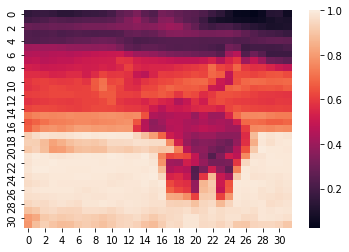

In [70]:
sns.heatmap(imgs[0].permute(1,2,0).numpy()[:,:,0])

In [71]:
labels[0]

tensor(4)

# ネットワークモデルの定義

In [72]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(3*32 * 32, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 10)
        )
    def forward(self, x):
        output = self.classifier(x)
        return output

In [73]:
model = MLP()
model.to(device)


MLP(
  (classifier): Sequential(
    (0): Linear(in_features=3072, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=400, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=400, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=200, out_features=10, bias=True)
  )
)

# 損失関数、最適化関数の定義

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習

In [75]:
%%time
num_epochs = 50
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.view(num_batches, -1)
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(imgs)

        loss = criterion(output, labels)
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)

        loss.backward()

        optimizer.step()

    running_loss /= len(train_dataloader)
    losses.append(running_loss)

    print("epoch: {}, loss: {}".format(epoch, running_loss))

epoch: 0, loss: 1.887550383090973
epoch: 1, loss: 1.6980498988628387
epoch: 2, loss: 1.6075320312976837
epoch: 3, loss: 1.5393222930431365
epoch: 4, loss: 1.4940261583328247
epoch: 5, loss: 1.4518884568214416
epoch: 6, loss: 1.4165439174175263
epoch: 7, loss: 1.3796410601139069
epoch: 8, loss: 1.3558774478435516
epoch: 9, loss: 1.3280145392417908
epoch: 10, loss: 1.300411966919899
epoch: 11, loss: 1.2749222543239593
epoch: 12, loss: 1.2532455393075943
epoch: 13, loss: 1.2289667460918428
epoch: 14, loss: 1.208147757411003
epoch: 15, loss: 1.1862474528551101
epoch: 16, loss: 1.1639900231361389
epoch: 17, loss: 1.1419823595285417
epoch: 18, loss: 1.1273513840436935
epoch: 19, loss: 1.1015184218883514
epoch: 20, loss: 1.0793258988857268
epoch: 21, loss: 1.064489258170128
epoch: 22, loss: 1.0456698639392852
epoch: 23, loss: 1.0269747911691665
epoch: 24, loss: 1.0072467880249023
epoch: 25, loss: 0.9890513002872467
epoch: 26, loss: 0.9700170114040375
epoch: 27, loss: 0.9581137264966965
epoch:

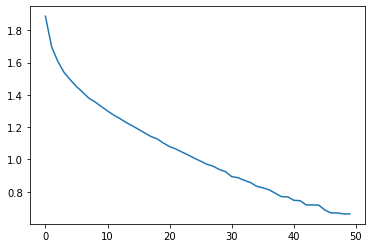

In [76]:
plt.plot(losses) # 誤差が減少していることを確認

# テスト

# 正解ラベル

In [77]:
train_iter = iter(train_dataloader)
imgs, labels = train_iter.next()
labels

tensor([3, 5, 5, 2, 2, 3, 5, 8, 1, 9, 9, 4, 8, 2, 5, 1, 6, 1, 3, 6, 5, 6, 9, 0,
        0, 7, 3, 4, 3, 4, 1, 1, 1, 8, 8, 2, 9, 1, 7, 1, 2, 0, 2, 4, 0, 5, 4, 9,
        3, 0, 2, 4, 3, 9, 7, 6, 9, 8, 6, 1, 3, 4, 1, 3, 8, 5, 2, 4, 0, 8, 1, 5,
        0, 8, 3, 6, 3, 5, 6, 2, 1, 6, 4, 9, 6, 1, 2, 6, 6, 8, 3, 5, 3, 6, 3, 0,
        3, 3, 0, 7])

# 予測結果

In [78]:
imgs_gpu = imgs.view(100, -1).to(device)
output= model(imgs_gpu)
pred = torch.argmax(output, dim=1)
pred

tensor([3, 3, 5, 2, 2, 3, 5, 8, 1, 9, 9, 4, 8, 6, 5, 9, 6, 1, 5, 6, 5, 6, 9, 6,
        0, 7, 3, 4, 1, 4, 1, 1, 1, 8, 8, 8, 1, 1, 7, 9, 2, 3, 2, 4, 1, 5, 4, 9,
        6, 0, 2, 4, 3, 9, 7, 6, 9, 8, 5, 1, 5, 4, 1, 3, 9, 5, 2, 4, 0, 9, 1, 0,
        0, 8, 3, 2, 3, 3, 6, 1, 1, 2, 0, 9, 5, 1, 2, 6, 6, 8, 3, 4, 3, 6, 3, 4,
        3, 3, 1, 7])

In [79]:
test_acc = 0
total = 0
for images, labels in test_dataloader:
    images, labels = images.view(num_batches, -1).to(device), labels.to(device)
    outputs = model(images)
    pred = torch.argmax(output, dim=1)
    test_acc += (pred  == labels).sum().item()
    total += labels.size(0)
    
    
print('正解数：　{} 個'.format(int(test_acc)))
print('正解率：　{} ％'.format(100*test_acc / total))

正解数：　996 個
正解率：　9.96 ％


# 上の正解ラベルと予測結果の数値がほぼ一致していることを確認